##Start Spark Session

In [1]:
# # Install Java, Spark, and Findspark
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q http://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
# !tar xf spark-2.4.5-bin-hadoop2.7.tgz
# !pip install -q findspark

# # Set Environment Variables
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

# # Start a SparkSession
# import findspark
# findspark.init()


## Mount Google Drive into this runtime 

To access your config file, you need to mount your google drive into this runtime. To do that, run the following cells.
This will prompt a URL with an authentication code. After you go to the URL and insert 

In [2]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
# %cd /content/gdrive/My Drive/data_final_project/mental_health_ML

## Create config.py file


*   List item
*   List item


In the **mental_health_ML** directory, create a file called **config.py** and add the following contents:

```bash
ACCESS_ID='AWS_ACCESS_KEY_ID'
ACCESS_KEY='AWS_SECRET_ACCESS_KEY'
BUCKET_NAME='S3_BUCKET_NAME'
```

Replace AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, and S3_BUCKET_NAME with their actual values. This file is in the .gitignore so that it won't be committed to GitHub.

In [4]:
# Database credentials
from config import DB_USERNAME, DB_PASSWORD, DB_ENDPOINT

# Used for making database connection.
# ! pip install sqlalchemy

from sqlalchemy import create_engine

In [5]:
# ! pip install psycopg2-binary

rds_connection_string = f"{DB_USERNAME}:{DB_PASSWORD}@{DB_ENDPOINT}:5432/mental_health_tech_db"
engine = create_engine(f'postgresql://{rds_connection_string}')

In [6]:
engine.table_names()

['survey_responses']

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import numpy as np
from sklearn.linear_model import LinearRegression

In [8]:
survey_df = pd.read_sql_query('select * from survey_responses', con=engine)

In [9]:
twenty14_df = survey_df.loc[survey_df['year'] == 2014, ['sought_treatment_for_mental_health']]
twenty14_results = np.unique(twenty14_df['sought_treatment_for_mental_health'])
print(twenty14_results)

[ True]


# Plotting True/False Percent Responses

In [10]:
predict_df = survey_df.loc[survey_df['year']>2016, ['year', 'sought_treatment_for_mental_health']]
participant_count = predict_df.groupby(['year']).size()
participant_count

year
2017    643
2018    361
2019    304
dtype: int64

In [11]:
treatment_count = predict_df.groupby(['year', 'sought_treatment_for_mental_health']).size()
treatment_count

year  sought_treatment_for_mental_health
2017  False                                 259
      True                                  384
2018  False                                 131
      True                                  230
2019  False                                 112
      True                                  192
dtype: int64

In [12]:
years = list(set(predict_df['year']))
try:
  treatment_precent_df = treatment_precent_df.drop(['year', 'sought_treatment_for_mental_health', 'sought_treatment_percentage'], axis=1)
except:
  print('These dataframe columns do not exist.')
  pass
year_col = []
treatment_result_col = []
treatment_percent_col = []
for i in range(len(years)):
  year_col.append(years[i])
  year_col.append(years[i])
  treatment_result_col.append(False)
  treatment_result_col.append(True)
  treatment_percent_col.append(treatment_count[years[i]][False] / participant_count[years[i]])
  treatment_percent_col.append(treatment_count[years[i]][True] / participant_count[years[i]])

treatment_precent_df = pd.DataFrame(list(zip(year_col, treatment_result_col, treatment_percent_col)),
                                    columns=['year', 'sought_treatment_for_mental_health', 'sought_treatment_percentage'])
treatment_precent_df

These dataframe columns do not exist.


,year,sought_treatment_for_mental_health,sought_treatment_percentage
0,2017,False,0.402799
1,2017,True,0.597201
2,2018,False,0.362881
3,2018,True,0.637119
4,2019,False,0.368421
5,2019,True,0.631579


In [31]:
def trueFalseBarPlot(ylabels, truePercent, falsePercent):
  x = np.arange(len(ylabels))  # the label locations
  width = 0.35  # the width of the bars

  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width/2, falsePercent, width, label='False')
  rects2 = ax.bar(x + width/2, truePercent, width, label='True')

  # Add some text for labels, title and custom x-axis tick labels, etc.
  plt.ylim(0, 1)
  ax.set_ylabel('Employees Who Sought Treatment (%)')
  ax.set_title('Survey Response Results by Year')
  ax.set_xticks(x)
  ax.set_xticklabels(ylabels)
  ax.legend()

  def autolabel(rects):
      """Attach a text label above each bar in *rects*, displaying its height."""
      for rect in rects:
          height = rect.get_height()
          ax.annotate('{:.2%}'.format(height),
                      xy=(rect.get_x() + rect.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom')


  autolabel(rects1)
  autolabel(rects2)

  fig.tight_layout()

  return plt

#   plt.show()

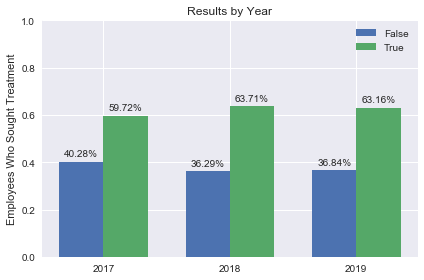

<module 'matplotlib.pyplot' from '/Users/abby/miniconda3/envs/PythonData/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [22]:

labels = list(set(predict_df['year']))
truePercent = treatment_precent_df.loc[treatment_precent_df['sought_treatment_for_mental_health'] == True,'sought_treatment_percentage']
falsePercent = treatment_precent_df.loc[treatment_precent_df['sought_treatment_for_mental_health'] == False,'sought_treatment_percentage']

trueFalseBarPlot(labels, truePercent, falsePercent)

In [15]:
regression_df = treatment_precent_df[treatment_precent_df['sought_treatment_for_mental_health']==True]
regression_df

x = regression_df[['year']]
y = regression_df['sought_treatment_percentage']

In [16]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(x, y)
print(model)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


In [17]:
reg = LinearRegression().fit(x,y)

print("Weight coefficients: ", model.coef_)
print("y-axis intercept: ", model.intercept_)
print(f"R2 value is: {reg.score(x, y)}")

Weight coefficients:  [0.01718916]
y-axis intercept:  -34.065763984324306
R2 value is: 0.6317794496136115


In [18]:
def soughtTreatmentPercentagePrediction(year):
  m = 0.01718916
  b = -34.0657639843243
  return (m * year) + b

In [36]:
predict_year = 2020
truePercentlist = list(truePercent)
prediction = soughtTreatmentPercentagePrediction(predict_year)
truePercentlist.append(prediction)
print(truePercentlist)

[0.5972006220839814, 0.6371191135734072, 0.631578947368421, 0.6563392156757004]


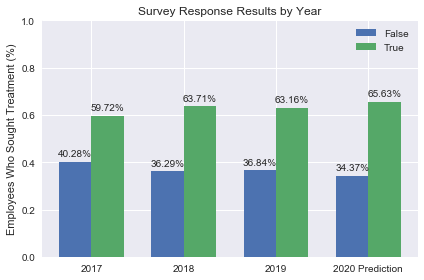

In [37]:
yearsPredict = list(set(predict_df['year']))
yearsPredict.append(f'{predict_year} Prediction')

prediction = soughtTreatmentPercentagePrediction(predict_year)
truePercentPredict = list(truePercent)
truePercentPredict.append(prediction)
falsePercentPredict = list(falsePercent)
falsePercentPredict.append(1-prediction)
trueFalseBarPlot(yearsPredict, truePercentPredict, falsePercentPredict)
plt.savefig(f"application/static/images/{predict_year}_Response_to_Treatment_Prediction.png", dpi=900)

In [40]:
yearsPredict
# truePercentPredict
# falsePercentPredict

[2017, 2018, 2019, '2020 Prediction']

In [50]:
# put data into a csv to upload into js to create a d3 plot
data = [pd.DataFrame(yearsPredict), pd.DataFrame(truePercentPredict), pd.DataFrame(falsePercentPredict)]
headers = ["Year", "TruePrecent", "FalsePercent"]
predictChart_df = pd.concat(data, axis=1, keys=headers)
predictChart_df.to_csv("application/static/predictChartData.csv")

